In [9]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import seaborn as sns
import numpy as np

In [2]:

df = pd.read_csv('creditcard.csv')


The columns are features: due to privacity we don't know the columns name but we have time and amount: Time is the difference between the each transaction and the first transaction dataset and Amount is the transaction amount

# EDA

## Ver a distribuição das classes
Vamos ver como as classes estão distribuídas, isso pode nos ajudar a entender um pouco melhor os dados, como há no geral poucos dados fraudulentos é esperado que hajam bem mais registros de dados não fraudulentos do que de fraudulentos

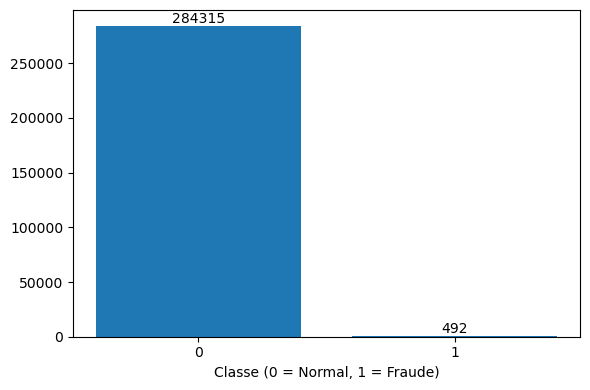

Percentual de dados fraudulentos: 0.173%
Percentual de dados não fraudulentos: 99.827%


In [3]:
class_count = df['Class'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(class_count.index.astype(str), class_count.values)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x()+bar.get_width()/2,
        height, 
        str(height),
        ha='center', 
        va='bottom'
    )
plt.xlabel('Classe (0 = Normal, 1 = Fraude)')
plt.tight_layout()
plt.show()
print(f"Percentual de dados fraudulentos: {round(100*class_count[1]/df.shape[0], 3)}%")
print(f"Percentual de dados não fraudulentos: {round(100*class_count[0]/df.shape[0], 3)}%")


## Estatística básica das variáveis
A ideia é olharmos para os números para entendermos melhor os dados

### Como as quantidades se relacionam com os dados fraudados

Podemos ver que a média dos dados fraudados ela é maior que a média dos dados normais mas a mediana não é, oque quer dizer que a maioria das transações fraudulentas, tem valores inferiores a media. E outra parte (75%) tem valores superiores, isso pode nos ajudar no futuro

In [4]:
fraude = df.where(df['Class'] == 1).describe()['Amount']
normal = df.where(df['Class'] == 0).describe()['Amount']
pd.DataFrame({'Normal': normal, 'Fraude': fraude})

,Normal,Fraude
count,284315.000000,492.000000
mean,88.291022,122.211321
std,250.105092,256.683288
min,0.000000,0.000000
25%,5.650000,1.000000
50%,22.000000,9.250000
75%,77.050000,105.890000
max,25691.160000,2125.870000


### Correlação entre as variáveis e os dados fraudados

Interessante notar que amount não está entre as principais variáveis que se relacionam com a classe. As principais são: V17, V14, V12 ,V10, V16, V3 e V7

In [5]:
correlations = df.corr(numeric_only=True)
class_correlations = correlations['Class'].drop('Class')
sorted_class_correlations = class_correlations.sort_values(key=abs, ascending=False)
print(sorted_class_correlations)

V17      -0.326481
V14      -0.302544
V12      -0.260593
V10      -0.216883
V16      -0.196539
V3       -0.192961
V7       -0.187257
V11       0.154876
V4        0.133447
V18      -0.111485
V1       -0.101347
V9       -0.097733
V5       -0.094974
V2        0.091289
V6       -0.043643
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
Time     -0.012323
V28       0.009536
V24      -0.007221
Amount    0.005632
V13      -0.004570
V26       0.004455
V15      -0.004223
V25       0.003308
V23      -0.002685
V22       0.000805
Name: Class, dtype: float64


In [6]:
def avaliar_modelo(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Normal', 'Fraude'],
        yticklabels=['Normal', 'Fraude']
    )
    plt.ylabel('Real')
    plt.xlabel('Previsto')
    plt.show()
    print(pd.DataFrame(report))

## Avaliando o modelo

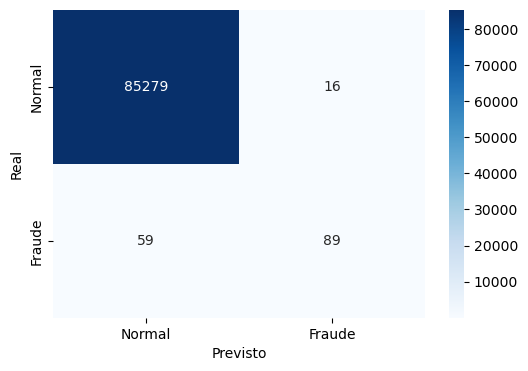

                      0           1  accuracy     macro avg  weighted avg
precision      0.999309    0.847619  0.999122      0.923464      0.999046
recall         0.999812    0.601351  0.999122      0.800582      0.999122
f1-score       0.999560    0.703557  0.999122      0.851559      0.999048
support    85295.000000  148.000000  0.999122  85443.000000  85443.000000


In [7]:
# Preparação dos dados
## Separação das variáveis
X = df.drop(columns=['Class'])
y = df['Class']
## Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Divisão treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Treinando o modelo e Avaliando desempenho
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

## Fazendo o modelo funcionar
y_pred = model.predict(X_test)
avaliar_modelo(y_test, y_pred)

## Utilizando um threshold

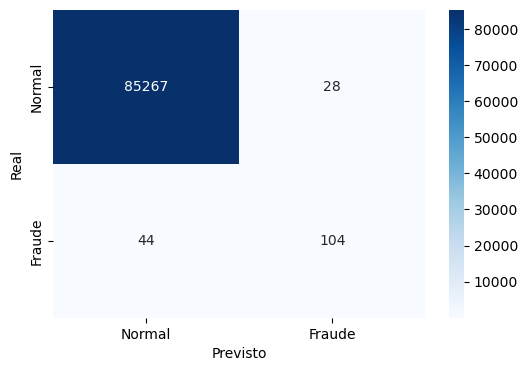

                      0           1  accuracy     macro avg  weighted avg
precision      0.999484    0.787879  0.999157      0.893682      0.999118
recall         0.999672    0.702703  0.999157      0.851187      0.999157
f1-score       0.999578    0.742857  0.999157      0.871218      0.999133
support    85295.000000  148.000000  0.999157  85443.000000  85443.000000


In [8]:
# Preparação dos dados
## Separação das variáveis
X = df.drop(columns=['Class'])
y = df['Class']
## Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Divisão treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Treinando o modelo e Avaliando desempenho
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1 = 2 * ( precision * recall) / (precision + recall)
best_threshold_idx = f1.argmax()
best_threshold = thresholds[best_threshold_idx]

# Fazer a previsão das probabilidades
y_probs = model.predict_proba(X_test)[:,1]

y_pred_threshold = (y_probs >= best_threshold).astype(int)

avaliar_modelo(y_test, y_pred_threshold)

In [11]:
auc_pr = auc(recall, precision)
print(f'Auc-pr: {auc_pr:.4f}')

Auc-pr: 0.7058
